# Lab EDA Bivariate Analysis

In [1]:
import os
print(os.getcwd())
print(os.listdir())

/Users/vlachaki/Desktop/Ironhack_projects/Week_5/Day_2/lab-eda-bivariate
['README.md', '.ipynb_checkpoints', '.git', 'lab_eda_bivariate.ipynb']


In [2]:
import pandas as pd

amazon_data = "../data/raw/amz_uk_price_prediction_dataset.csv"
amazon_df = pd.read_csv(amazon_data, encoding='ISO-8859-1')
amazon_df.head(10)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
5,6,B09B97WSLF,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
6,7,B09B9615X2,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
7,8,B01MTB55WH,Anker Soundcore 2 Portable Bluetooth Speaker w...,4.7,103673,39.99,False,0,Hi-Fi Speakers
8,9,B016MO90GW,"Bluetooth Speaker, Anker Soundcore Speaker Upg...",4.7,29909,29.99,False,0,Hi-Fi Speakers
9,10,B09ZQF5GZW,RIENOK Bluetooth Speaker Portable Wireless Blu...,4.5,16014,29.99,False,0,Hi-Fi Speakers


In [3]:
amazon_df.shape

(2443651, 9)

## Part 1: Analyzing Best-Seller Trends Across Product Categories

Objective: Understand the relationship between product categories and their best-seller status.

Crosstab Analysis:
- Create a crosstab between the product category and the isBestSeller status.
- Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.


In [4]:
cross_df = pd.crosstab(amazon_df["category"], amazon_df["isBestSeller"])
cross_df

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [5]:
prev = (cross_df[True] / cross_df.sum(axis=1)).sort_values(ascending=False)
prev.head(20)


category
Grocery                           0.058135
Smart Home Security & Lighting    0.057692
Health & Personal Care            0.057686
Mobile Phone Accessories          0.042471
Power & Hand Tools                0.035339
Billiard, Snooker & Pool          0.032129
Pet Supplies                      0.030200
Home Brewing & Wine Making        0.028455
Mirrors                           0.028000
Wind Instruments                  0.028000
Professional Medical Supplies     0.027344
PC & Video Games                  0.025466
Bakeware                          0.025105
Material Handling Products        0.025000
Bedding Accessories               0.024390
Tableware                         0.024096
Arts & Crafts                     0.024086
Baby                              0.022658
Lighting                          0.022556
Window Treatments                 0.020921
dtype: float64

In [6]:
# There is no category that has more best sellers that not, however, we can see that there are categories with a decent proportion of best sellers.

Statistical Tests:

- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
- Compute Cramér's V to understand the strength of association between best-seller status and category.


In [7]:
from scipy.stats import chi2_contingency

# Chi-square test for 'isBestSeller' and 'category'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(cross_df)

chi2_statistic, chi2_p_value

(np.float64(36540.20270061387), np.float64(0.0))

In [8]:
# the null hypothesis of the chi test is that the best-seller distribution is independent of the product category. 
# With a p-value being 0.0 we can reject that hypothesis. That implies that there is a significant association between best-sellers and product categories

In [9]:
from scipy.stats.contingency import association

association(cross_df, method="cramer")

0.1222829439760564

In [10]:
# The Cramér's V value of 0.148 suggests a weak association between the two variables. 
# Though statistically significant, the strength of this relationship is not very strong in practical terms.

Visualizations:

- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

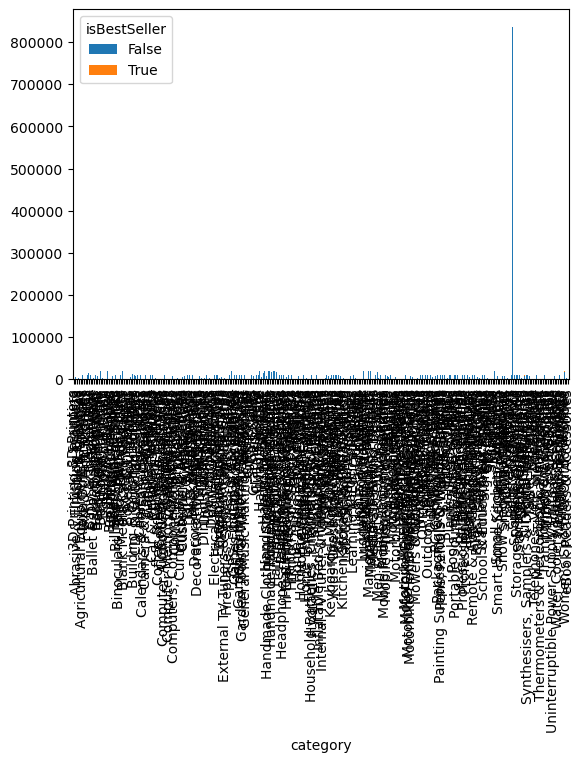

In [11]:
cross_df.plot(kind="bar", stacked=True);

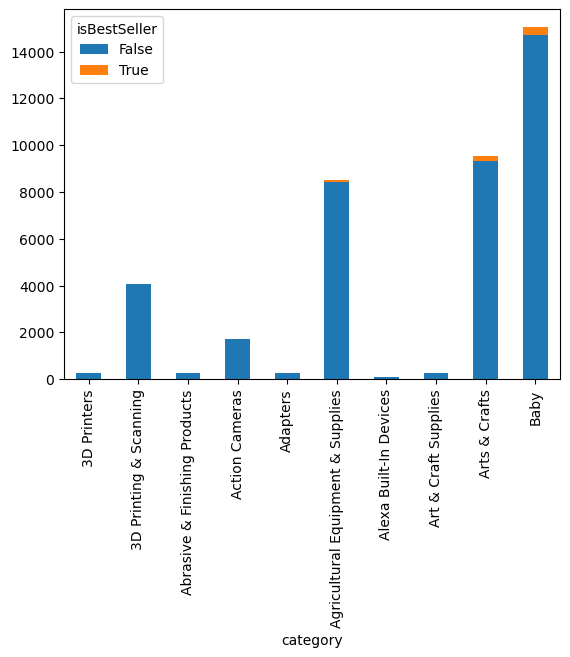

In [12]:
# there to many observations to be able to see anyhting. Therefore, I will draw the same chart but only for the top 10 products.
cross_df.head(10).plot(kind="bar", stacked=True);

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands

Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.
- For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
- Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [13]:
before = len(amazon_df)
before

2443651

In [14]:
q1 = amazon_df["price"].quantile(0.25)
q3 = amazon_df["price"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

mask = amazon_df["price"].between(lower, upper)

amazon_df = amazon_df.loc[mask].copy()
amazon_df.head(10)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
5,6,B09B97WSLF,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
6,7,B09B9615X2,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
7,8,B01MTB55WH,Anker Soundcore 2 Portable Bluetooth Speaker w...,4.7,103673,39.99,False,0,Hi-Fi Speakers
8,9,B016MO90GW,"Bluetooth Speaker, Anker Soundcore Speaker Upg...",4.7,29909,29.99,False,0,Hi-Fi Speakers
9,10,B09ZQF5GZW,RIENOK Bluetooth Speaker Portable Wireless Blu...,4.5,16014,29.99,False,0,Hi-Fi Speakers


In [15]:
after = mask.sum()
after

np.int64(2115963)

In [16]:
amazon_df.shape

(2115963, 9)

In [17]:
outliers_dropped = before - after
outliers_dropped

np.int64(327688)

In [18]:
# so we have 327688 outliers droppes

Violin Plots:

- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
- Which product category tends to have the highest median price? Don't filter here by top categories.


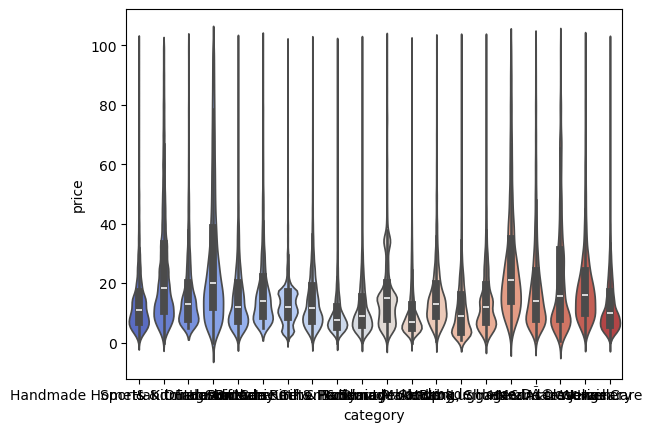

In [19]:
import seaborn as sns
top_20 = amazon_df["category"].value_counts().head(20).index
df_top_20 = amazon_df[amazon_df["category"].isin(top_20)]
sns.violinplot(data=df_top_20, x='category', y='price', palette="coolwarm", hue='category', legend=False);

In [20]:
med_by_cat = amazon_df.groupby("category")["price"].median()
highest_cat = med_by_cat.idxmax()
highest_median = med_by_cat.max()

highest_cat, highest_median


('Desktop PCs', 74.0)

Bar Charts:

- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
- Which product category commands the highest average price? Don't filter here by top categories.

In [21]:
# Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
top_10 = amazon_df["category"].value_counts().head(10).index
top_10_df = amazon_df[amazon_df["category"].isin(top_10)]
grouped_top_10 = top_10_df.groupby("category")["price"].mean()

grouped_top_10 = grouped_top_10.sort_values(ascending=False)
grouped_top_10_df = pd.DataFrame(grouped_top_10)
grouped_top_10_df

,price
category,
Sports & Outdoors,25.172065
Birthday Gifts,18.600195
Handmade Gifts,17.395112
Skin Care,15.654722
Bath & Body,14.678683
Hair Care,13.461408
"Handmade Clothing, Shoes & Accessories",12.958639
Beauty,12.523480
Make-up,10.612918


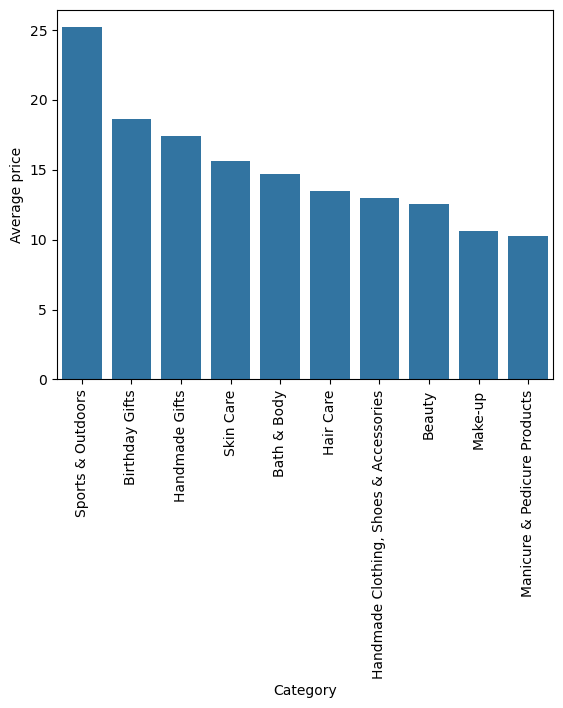

In [22]:
import matplotlib.pyplot as plt

ax = sns.barplot(data=grouped_top_10_df, x="category", y="price")
ax.set_ylabel("Average price")
ax.set_xlabel("Category")
plt.xticks(rotation=90)
plt.show()

In [24]:
# Which product category commands the highest average price? Don't filter here by top categories.
mean_by_cat_2 = amazon_df.groupby("category")["price"].mean()
highest_cat_2 = mean_by_cat_2.idxmax()
highest_mean_2 = mean_by_cat_2.max()

highest_cat_2, highest_mean_2

('Motherboards', 68.77243243243242)

In [39]:
# the category Motherboards has the highest average price

Box Plots:

- Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

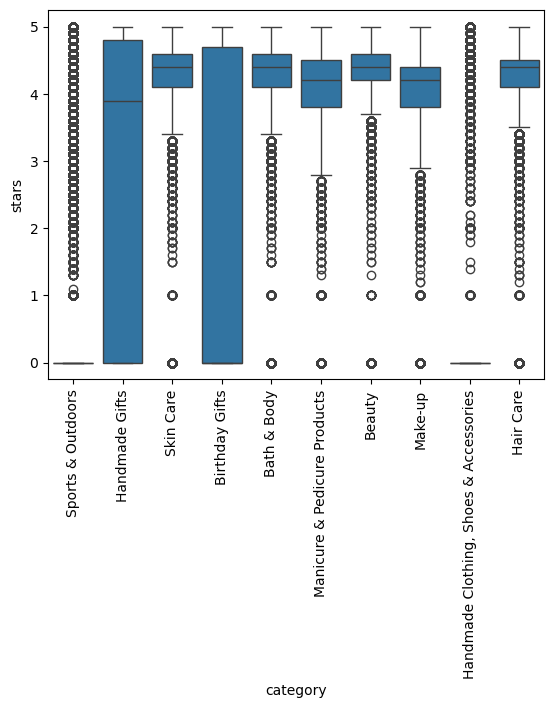

In [40]:
# - Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.

sns.boxplot(data=top_10_df, x="category", y="stars")
plt.xticks(rotation=90)
plt.xlabel("category")
plt.ylabel("stars")
plt.show()

In [26]:
# Which category tends to receive the highest median rating from customers? Don't filter here by top categories.
med_by_cat_3 = amazon_df.groupby("category")["stars"].median()
highest_cat_3 = med_by_cat_3.idxmax()
highest_median_3 = med_by_cat_3.max()

highest_cat_3, highest_median_3

('Computer Memory', 4.7)

In [27]:
# The category with the highest mediam rating is "Computer Moemory" 

## Part 3: Investigating the Interplay Between Product Prices and Ratings

Objective: Analyze how product ratings (stars) correlate with product prices.

Correlation Coefficients:

- Calculate the correlation coefficient between price and stars.
- Is there a significant correlation between product price and its rating?

In [30]:
correlation = amazon_df['price'].corr(amazon_df['stars'])
correlation

np.float64(-0.07767299878181352)

In [31]:
correlation_2 = amazon_df['price'].corr(amazon_df['stars'], method="spearman")
correlation_2

np.float64(-0.06679697280768393)

In [32]:
# there is a non significant negative correlation between price and ratings.

Visualizations:

- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
- Use a correlation heatmap to visualize correlations between all numerical variables.
- Examine if product prices typically follow a normal distribution using a QQ plot.

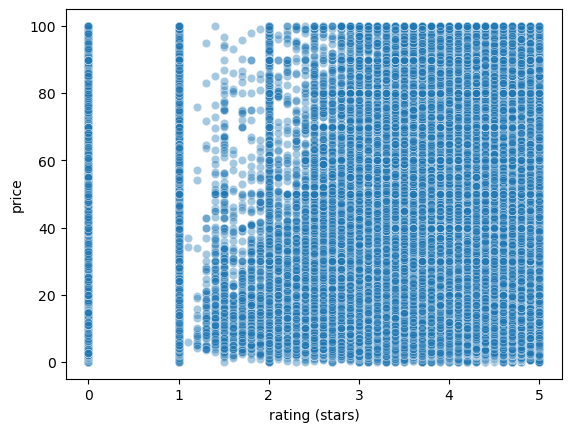

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=amazon_df, x="stars", y="price", alpha=0.4)
plt.xlabel("rating (stars)")
plt.ylabel("price")
plt.show()


In [34]:
# i see that, besides the rating 0 and 1 that shows no correlation whatsoever with price, for ratings bigger than 1, there is a slight positive correlation between rating and price.

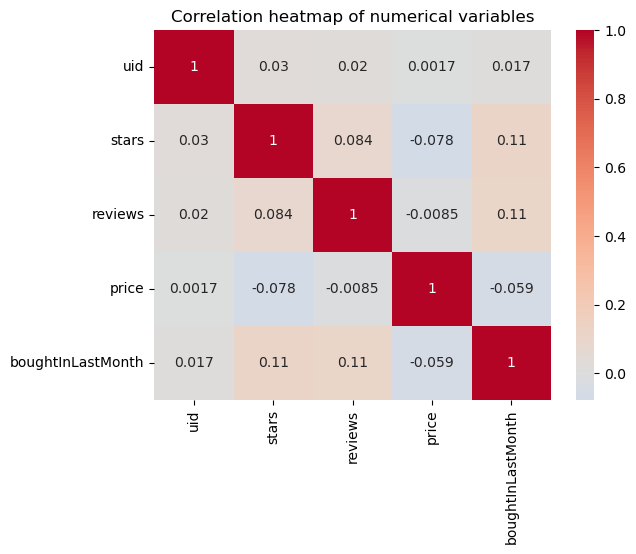

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

num_df = amazon_df.select_dtypes(include="number")
corr = num_df.corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation heatmap of numerical variables")
plt.show()


In [36]:
# we see very weak correlations throughout.

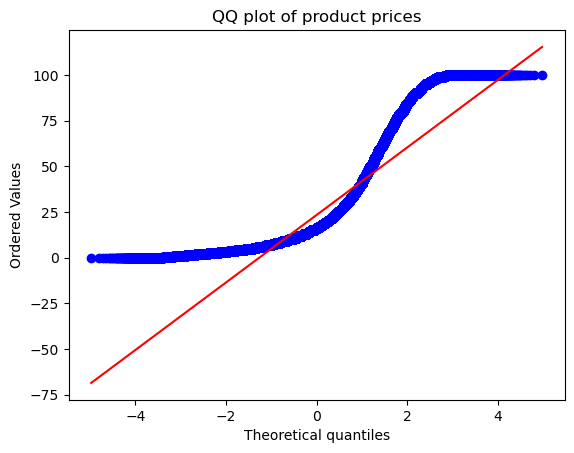

In [37]:
import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(amazon_df["price"], dist="norm", plot=plt)
plt.title("QQ plot of product prices")
plt.show()


In [38]:
# if prices would follow a normal distribution then the observations would be very close to the straight line. That is not the case.